In [13]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from transformers import AutoImageProcessor, ViTMAEForPreTraining

from my_hms_models import transform_spectrogram

TRAIN_EEG_DIR = Path('./inputs/hms-harmful-brain-activity-classification/train_eegs')
TRAIN_SPECS_DIR = Path('./inputs/hms-harmful-brain-activity-classification/train_spectrograms/')
TRAIN_CSV = Path('./inputs/hms-harmful-brain-activity-classification/train.csv')

PRE_LOADED_SPECTOGRAMS = Path('./inputs/brain-spectrograms/specs.npy')
PRE_LOADED_EEGS = Path('./inputs/brain-eeg-spectrograms/eeg_specs.npy')


TEST_DYPES ={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

In [2]:
train_df = pd.read_csv(TRAIN_CSV, dtype=TEST_DYPES)

all_specs = np.load( PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
all_eegs = np.load( PRE_LOADED_EEGS, allow_pickle=True).item()

In [3]:
def load_spec_from_parquet(spec_id, spec_offset, all_specs=None):

    prefixes = ['LL', 'RL', 'LP', 'RP']
    spec_array = np.zeros((4, 100, 300))

    if not all_specs:
        spec_df = pd.read_parquet(TRAIN_SPECS_DIR/f"{spec_id}.parquet")
        start_spec = spec_offset
        end_spec = start_spec + 600
        spec_section = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]
            
        for i, prefix in enumerate(prefixes):
            cols = spec_section.filter(regex=f"^{prefix}_").columns
            _arr = spec_section[cols].values.T
            spec_array[i] =  transform_spectrogram(_arr)

    else:
        r = spec_offset // 2
        for region, prefix in enumerate(prefixes):
            _arr = all_specs[spec_id][r:r+300, region*100:(region+1)*100].T
            spec_array[region] = transform_spectrogram(_arr)

    return spec_array

In [4]:
rows = train_df.sample(8)
spec_arrays = [
    load_spec_from_parquet(row["spectrogram_id"], row["spectrogram_label_offset_seconds"], all_specs)
    for _, row in rows.iterrows()
]

In [5]:
spec_arrays[0].shape

(4, 100, 300)

In [9]:
def create_input_array(array):
    # input shape: C, H, W

    # concat rows
    layer_1 = np.concatenate([array[0], array[1]], axis=0)
    layer_2 = np.concatenate([array[2], array[3]], axis=0)
    layer_3 = layer_1 - layer_2

    out_array = np.zeros((3, 224, 224))
    out_array[0, 12:-12] = layer_1[:, 38:-38]
    out_array[1, 12:-12] = layer_2[:, 38:-38]
    out_array[2, 12:-12] = layer_3[:, 38:-38]

    return out_array

input_arrays = np.array([create_input_array(arr) for arr in spec_arrays])
print(input_arrays[0].shape)

(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


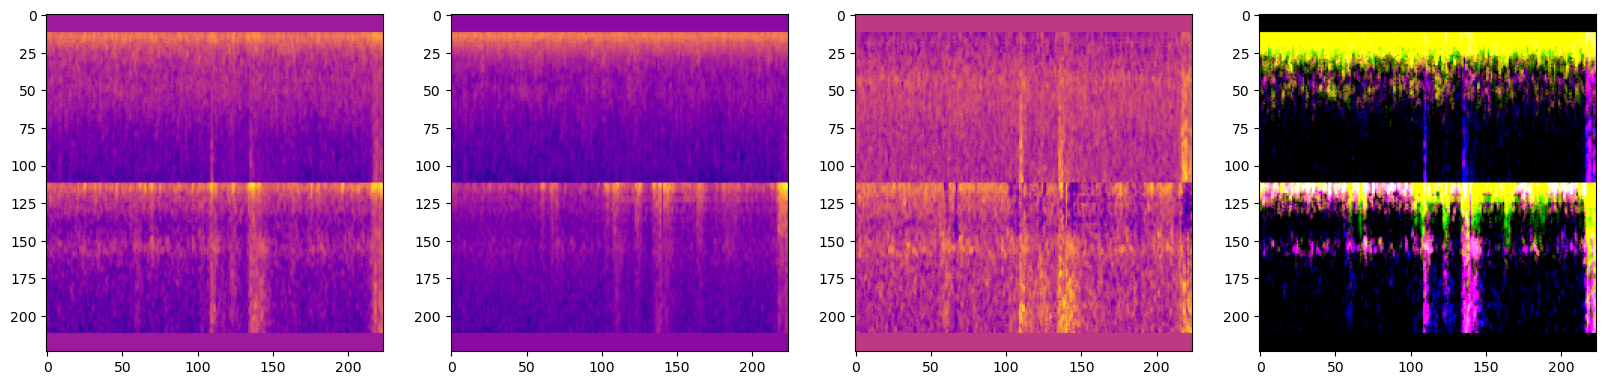

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(input_arrays[0][0], cmap='plasma')
ax[1].imshow(input_arrays[0][1], cmap='plasma')
ax[2].imshow(input_arrays[0][2], cmap='plasma')
ax[3].imshow(np.stack(input_arrays[0], axis=-1))
plt.show()

In [14]:
img_tensor = torch.tensor(input_arrays).float()

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

outputs = model(img_tensor)

In [15]:
img_tensor.shape

torch.Size([8, 3, 224, 224])

In [38]:
def show_image(im_layer, title=''):
    plt.imshow(im_layer)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model, sample_id, color_range=[-5, 5]):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    print(y.shape)
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    cmp_kwargs = dict(cmap='plasma', vmin=color_range[0], vmax=color_range[1])
    for i in range(3):
        axes[0, i].imshow(x[sample_id, :, :, i], **cmp_kwargs)
        axes[1, i].imshow(y[sample_id, :, :, i], **cmp_kwargs)
        axes[0, i].set_title(f'Layer {i}')
    
    axes[0, 3].imshow(x[sample_id], **cmp_kwargs)
    axes[1, 3].imshow(y[sample_id], **cmp_kwargs)

    axes[0, 3].set_title('3-channel input')
    axes[0, 0].set_ylabel('Input')
    axes[1, 0].set_ylabel('Reconstruction')

    fig.tight_layout()
    plt.show()

    print(outputs.loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 224, 224, 3])


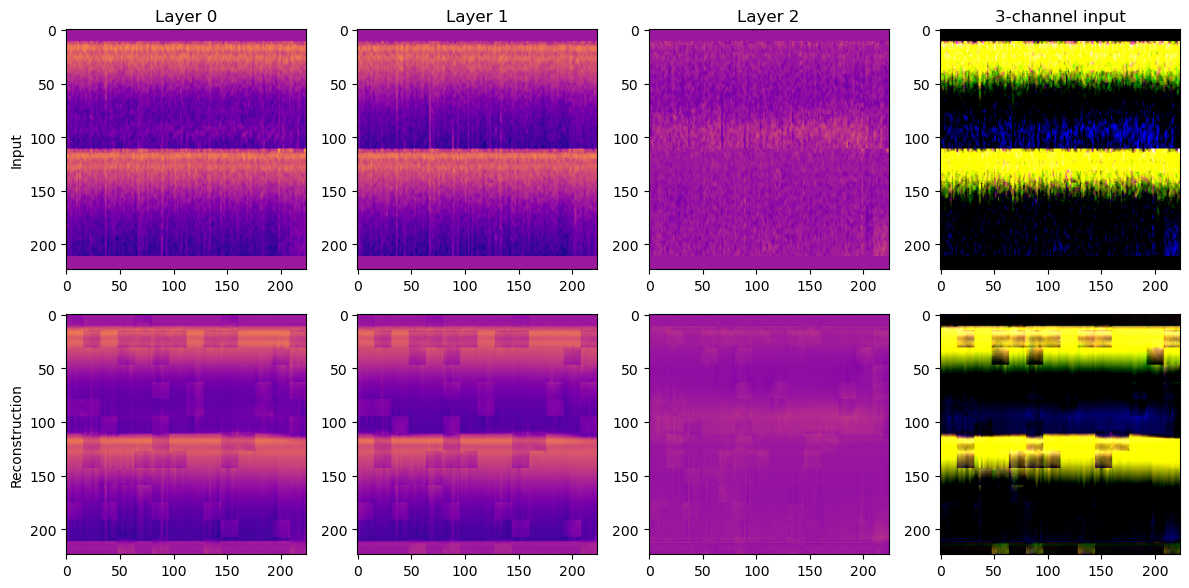

tensor(0.1092, grad_fn=<DivBackward0>)


In [40]:
visualize(img_tensor, model, 6, color_range=[-2, 4])